# Imports and some methods

In [1]:
import librosa
import librosa.display
import glob, os, json
import numpy as np
from scipy.io import wavfile
import string
import random, shutil
import librosa
import librosa.display
import pandas as pd
import matplotlib.pyplot as plt

dataDir = 'Data/'
testDir = 'TestData/'
subdirs = ['1/', '2/', '3/', '4/', '5/']
compressionCoefs = [1.0, 3/4, 7/4, 5/6, 3/2]


def randomString(length):
    """Generate a random string of fixed length """
    letters = string.ascii_uppercase + string.digits
    return ''.join(random.choice(letters) for i in range(length))

def normalize_audio(audio):
    #audio = audio / np.max(np.abs(audio))
    for ind,freq in enumerate(audio):
        audio[ind] = freq / np.max(np.abs(freq))
    return audio

## Noise functions
Noise adding functions original got from [Kaggle](https://www.kaggle.com/ejlok1/audio-emotion-part-5-data-augmentation)

In [2]:
def noise(data):
    """
    Adding White Noise.
    """
    # you can take any distribution from https://docs.scipy.org/doc/numpy-1.13.0/reference/routines.random.html
    noise_amp = 0.05*np.random.uniform()*np.amax(data)   # more noise reduce the value to 0.5
    data = data.astype('float64') + noise_amp * np.random.normal(size=data.shape[0])
    return data
    
def shift(data):
    """
    Random Shifting.
    """
    s_range = int(np.random.uniform(low=-5, high = 5)*1000)  #default at 500
    return np.roll(data, s_range)
    
def stretch(data, rate=0.8):
    """
    Streching the Sound. Note that this expands the dataset slightly
    """
    data = librosa.effects.time_stretch(data, rate)
    return data
    
def pitch(data, sample_rate):
    """
    Pitch Tuning.
    """
    bins_per_octave = 12
    pitch_pm = 2
    pitch_change =  pitch_pm * 2*(np.random.uniform())   
    data = librosa.effects.pitch_shift(data.astype('float64'), 
                                      sample_rate, n_steps=pitch_change, 
                                      bins_per_octave=bins_per_octave)
    return data
    
def dyn_change(data):
    """
    Random Value Change.
    """
    dyn_change = np.random.uniform(low=-0.5 ,high=7)  # default low = 1.5, high = 3
    return (data * dyn_change)
    
def speedNpitch(data):
    """
    peed and Pitch Tuning.
    """
    # you can change low and high here
    length_change = np.random.uniform(low=0.8, high = 1)
    speed_fac = 1.2  / length_change # try changing 1.0 to 2.0 ... =D
    tmp = np.interp(np.arange(0,len(data),speed_fac),np.arange(0,len(data)),data)
    minlen = min(data.shape[0], tmp.shape[0])
    data *= 0
    data[0:minlen] = tmp[0:minlen]
    return data

# Data manipulation

In [3]:
try:
    shutil.rmtree('TestData')
except:
    pass

functionList = [noise, shift, stretch, dyn_change, speedNpitch]

for sub in subdirs:
    lst = os.listdir(dataDir + sub)
    if not os.path.exists(testDir + sub):
        os.makedirs(testDir + sub)
    
    for name in lst:
        fs, data = wavfile.read(dataDir + sub + name)
        librosaData, sampling_rate = librosa.load(dataDir + sub + name)
 
        # add noise to sound with functions
        for func in functionList:
            newLibrosaData = func(librosaData)
            librosa.output.write_wav(testDir + sub + name.split('.')[0] + \
                                     randomString(20) + '.wav', newLibrosaData, sampling_rate)
            
        librosaData = pitch(librosaData, sampling_rate)
        librosa.output.write_wav(testDir + sub + name.split('.')[0] + \
                                 randomString(20) + '.wav', librosaData, sampling_rate)
        
        # play with frequency
        for coef in compressionCoefs:
            wavfile.write(rate= int(fs*coef), filename= testDir \
                          + sub + name.split('.')[0] + randomString(20) + '.wav', data= data) 

In [4]:
def plot_mfcc(number, N=3):
    random.shuffle(samples[number])
    print('Displaying mfccs of number ' + str(number))
    for mfcc in samples[number][:N]:
        plt.figure(figsize=(10, 4))
        mfcc = np.asarray(mfcc).T
        librosa.display.specshow(mfcc, x_axis='time')
        plt.colorbar()
        plt.title('MFCC')
        plt.tight_layout()
    plt.show()

In [5]:
sub_dirs = ['1', '2', '3', '4', '5']
parent_dir = 'TestData'
file_ext="*.wav" # change to "*.wav" to read all voices
samples = {1:[], 2:[], 3:[], 4:[], 5:[]}
n_mfcc = 32

for num, sub_dir in enumerate(sub_dirs):
    num_dir = int(sub_dir)
    for fn in glob.glob(os.path.join(parent_dir, sub_dir, file_ext)):
        sound_clip,s = librosa.load(fn)
        mfcc = librosa.feature.mfcc(y=sound_clip, sr=s, n_mfcc=n_mfcc)
        mfcc = normalize_audio(mfcc.T)
        mfcc = mfcc.tolist()
        samples[num_dir].append(mfcc)
        

Displaying mfccs of number 5


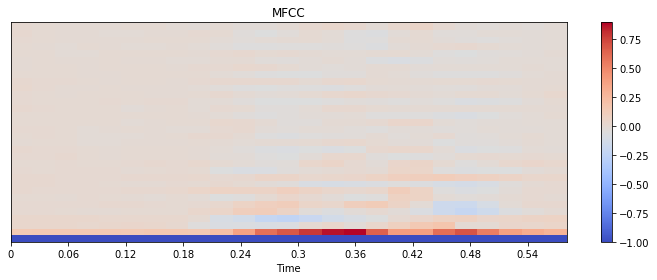

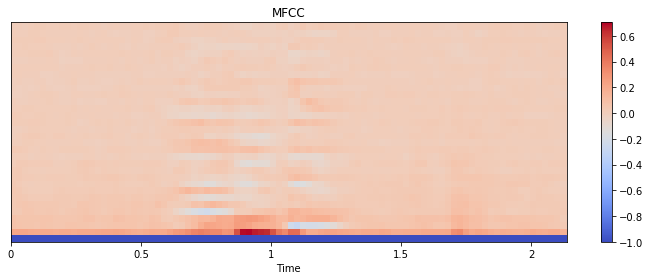

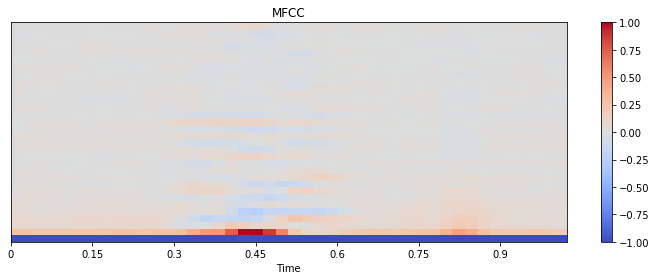

In [6]:
plot_mfcc(number=5)

In [7]:
data_path = os.path.join('Data', 'mfcc_samples.json')
f = open(data_path, "w")
json.dump(samples, f)
f.close()